In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [3]:
directory = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85'

I_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_header = I_hdu.header
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)

I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

freqs_lower = np.zeros(12)
freqs_middle = np.zeros(12)
freqs_upper = np.zeros(12)

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freqs_lower[n] = I_hdu.header['FREL'+number]
    freqs_middle[n] = I_hdu.header['FREQ'+number]
    freqs_upper[n] = I_hdu.header['FREH'+number]

In [4]:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto(directory + r'\Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

In [5]:
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)


In [6]:
daofind = DAOStarFinder(fwhm=3.0, threshold=3.5*backgr_std)

mask = np.ones(linpol_intens_freqmean.shape, dtype=bool)
mask[1600:1700, 1250:1350] = False
mask[1100:1200, 1500:1600] = False
mask[1300:1500, 1200:1400] = False
sources_compar = daofind(linpol_intens_freqmean - backgr_median, mask=mask)
for col in sources_compar.colnames:
    sources_compar[col].info.format = '%.8g'  # for consistent table output
print(sources_compar)

 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag    
--- --------- --------- ---------- ... --- ------------- --------- -----------
  1 1574.1474 1124.9486 0.39922598 ...   0 0.00090003421 9.9840803  -2.4982702
  2 1564.6967 1137.2616 0.40011825 ...   0 0.00017359151 1.9636412 -0.73265533
  3 1560.8153 1141.9812 0.39641346 ...   0 0.00036038106 3.8264251   -1.456983
  4  1356.121 1404.4902 0.39600383 ...   0 0.00010838422 1.1268673 -0.12968196
  5 1290.9782 1658.5458 0.39955294 ...   0  0.0015098529 16.715295  -3.0577851


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'SPECLNMF'  'STOKES'  
CRVAL : 10.45282638889222  -9.317925555555556  1283791015.625  1.0  
CRPIX : 1809.0  1809.0  1.0  1.0  
NAXIS : 3617  3617  12  1


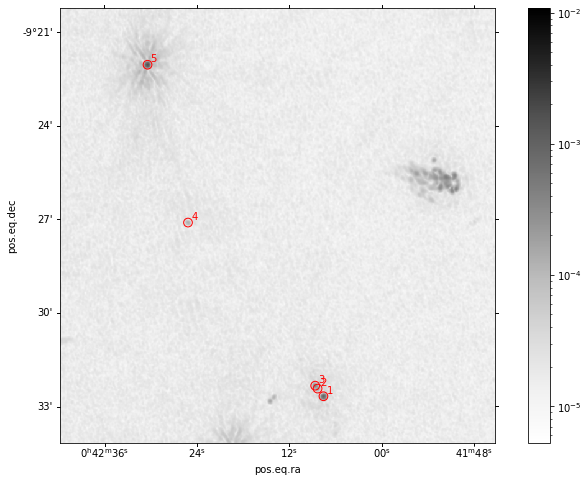

In [7]:
from photutils.aperture import CircularAperture
positions_compar = np.transpose((sources_compar['xcentroid'], sources_compar['ycentroid']))
apertures_compar = CircularAperture(positions_compar, r=7.)

plt.figure(figsize=(12,8))
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
plt.ylim(1050,1750)
plt.xlim(1150,1850)
apertures_compar.plot(color='red', lw=1)
for n in range(5):
    plt.text(sources_compar['xcentroid'][n]+5, sources_compar['ycentroid'][n]+5, sources_compar['id'][n], color='red')
plt.savefig('ACO85_Linpol_FreqmeanSourcedetect.pdf', dpi=300)

print(I_wcs)
#print(apertures_compar.to_sky(I_wcs))

In [8]:
#annulus_apertures_compar = CircularAnnulus(positions_compar, r_in=8., r_out=13.)
#apers_compar = [apertures_compar, annulus_apertures_compar]
FWHM_major_axis = 2.140979E-03*c.degree
FWHM_minor_axis = 1.972437E-03*c.degree
pixsize = 3.317774E-04*c.degree
print(FWHM_major_axis)

def photometry(data_local, apers_local, psize, min_ax, maj_ax):
    data_local_intensity = data_local*4*np.log(2)/(np.pi*maj_ax*min_ax)
    phot_table = aperture_photometry(data_local_intensity, apers_local)
    phot_mean = phot_table['aperture_sum']/apers_local.area
    flux = phot_mean*apers_local.area*(psize**2)
    phot_table['flux'] = flux
    return phot_table

phot_table_compar = photometry(linpol_intens_freqmean, apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
print(apertures_compar[0].area)
print(phot_table_compar)

3.7367132766055673e-05
153.93804002589985
 id      xcenter       ...    aperture_sum             flux         
           pix         ...                                          
--- ------------------ ... ------------------ ----------------------
  1 1574.1473878079303 ...  28431329.22645449  0.0009533349138974699
  2 1564.6966903277728 ... 11389089.851494972 0.00038188917959005675
  3  1560.815257203651 ... 14192657.428782342 0.00047589599979922556
  4 1356.1209625517888 ...  5168987.520831427 0.00017332205025869063
  5 1290.9782154774423 ...  46705818.85035536    0.00156609940525693


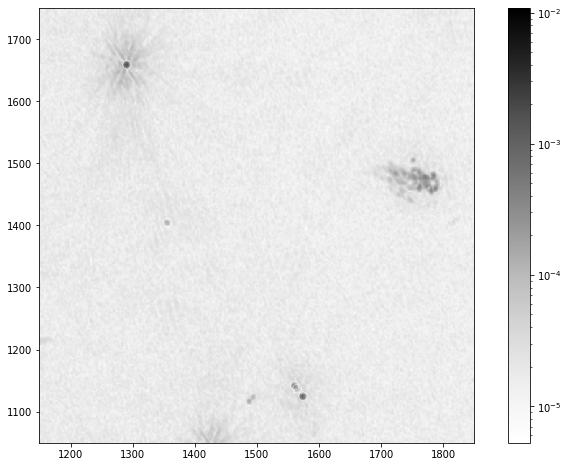

In [9]:
plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()

ap_patches_compar = apertures_compar.plot(color='white', lw=0.5, label='Photometry aperture')
#ann_patches_compar = annulus_apertures_compar.plot(color='blue', lw=0.5, label='Background annulus (VLA compar)')
#handles_compar = (ap_patches_compar[0], ann_patches_compar[0])
#plt.legend(facecolor='#458989', labelcolor='white', handles=ap_patches_compar[0], prop={'weight': 'bold', 'size': 11})
plt.ylim(1050,1750)
plt.xlim(1150,1850)
plt.savefig('ACO85_Linpol_Photometry.pdf', dpi=300)

In [10]:
I_phot_table_compar = np.zeros((12, len(sources_compar)))
Q_phot_table_compar = np.zeros((12, len(sources_compar)))
U_phot_table_compar = np.zeros((12, len(sources_compar)))
V_phot_table_compar = np.zeros((12, len(sources_compar)))

for n in range(12):
    I_slice_phot_compar = photometry(I_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    Q_slice_phot_compar = photometry(Q_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    U_slice_phot_compar = photometry(U_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    V_slice_phot_compar = photometry(V_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    for i in range(len(sources_compar)):
        I_phot_table_compar[n, i] = I_slice_phot_compar[i]['flux']
        Q_phot_table_compar[n, i] = Q_slice_phot_compar[i]['flux']
        U_phot_table_compar[n, i] = U_slice_phot_compar[i]['flux']
        V_phot_table_compar[n, i] = V_slice_phot_compar[i]['flux']

print(np.shape(I_phot_table_compar))

(12, 5)


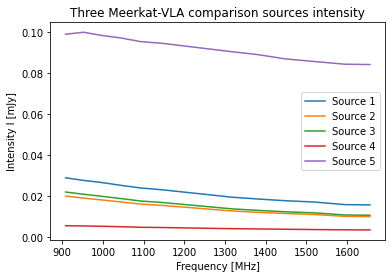

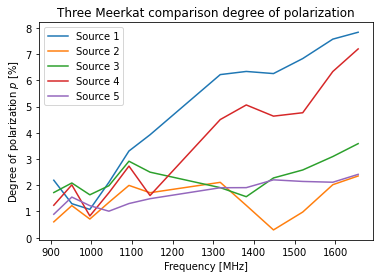

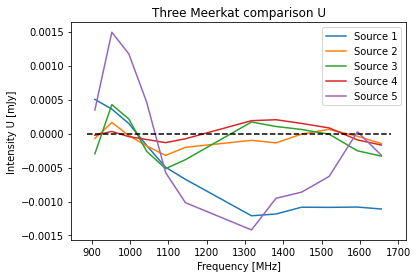

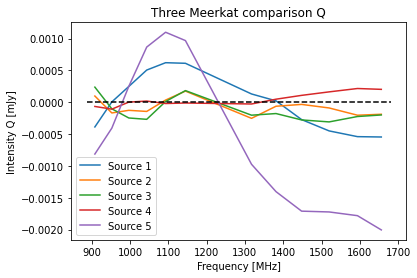

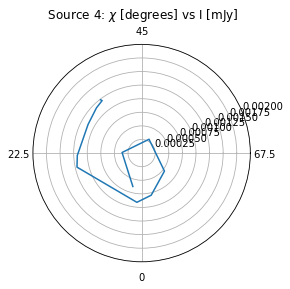

In [11]:
Pol_Angles_compar = 0.5*np.arctan(U_phot_table_compar/Q_phot_table_compar)
Linpol_compar = np.sqrt(U_phot_table_compar**2 + Q_phot_table_compar**2)

Labels = ['Source 1', 'Source 2', 'Source 3', 'Source 4', 'Source 5']
plt.title('Three Meerkat-VLA comparison sources intensity')
plt.plot(freqs_middle/1e6, I_phot_table_compar, label=Labels)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison degree of polarization')
plt.plot(freqs_middle/1e6, 100*Linpol_compar/I_phot_table_compar, label=Labels)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison U')
plt.plot(freqs_middle/1e6, U_phot_table_compar, label=Labels)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison Q')
plt.plot(freqs_middle/1e6, Q_phot_table_compar, label=Labels)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_compar[:,0], Linpol_compar[:,0])
ax.set_rmax(0.002)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 4: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [12]:
Freqs_VLA = np.loadtxt(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data\lambda_squared.txt', dtype=float)[:,1]*1e9

I_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
I_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))

fname_pt1 = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data\Abell_85_photometry\Stokes_'
fname_pt2 = r'\Stokes'
fname_pt3 = r'cor_source_'
fname_pt4 = r'_unc_source_'

for n in range(5):
    I_phot_table_VLA[:,n] = np.load(fname_pt1+'I'+fname_pt2+'I'+fname_pt3+str(n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA[:,n] = np.load(fname_pt1+'Q'+fname_pt2+'Q'+fname_pt3+str(n)+'.npy', allow_pickle=True)
    U_phot_table_VLA[:,n] = np.load(fname_pt1+'U'+fname_pt2+'U'+fname_pt3+str(n)+'.npy', allow_pickle=True)
    I_phot_table_VLA_err[:,n] = np.load(fname_pt1+'I'+fname_pt2+'I'+fname_pt4+str(n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA_err[:,n] = np.load(fname_pt1+'Q'+fname_pt2+'Q'+fname_pt4+str(n)+'.npy', allow_pickle=True)
    U_phot_table_VLA_err[:,n] = np.load(fname_pt1+'U'+fname_pt2+'U'+fname_pt4+str(n)+'.npy', allow_pickle=True)
print(np.shape(I_phot_table_VLA))
print(np.shape(I_phot_table_VLA_err))

(90, 5)
(90, 5)


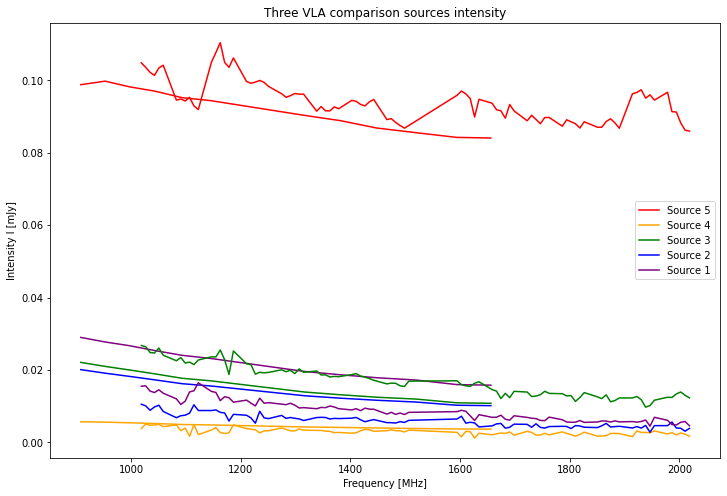

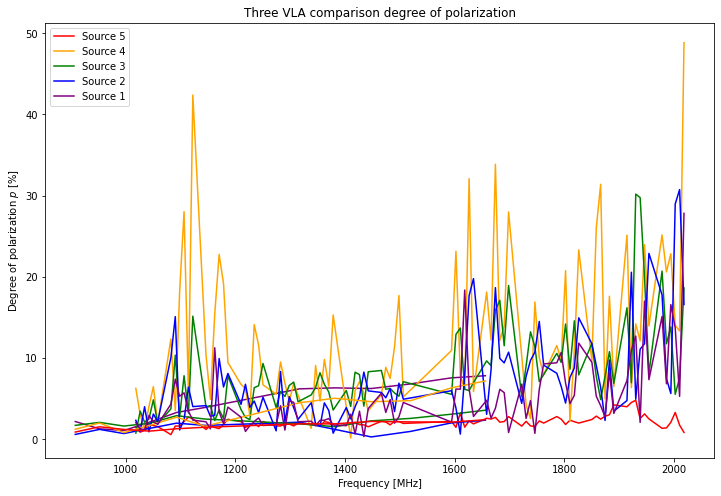

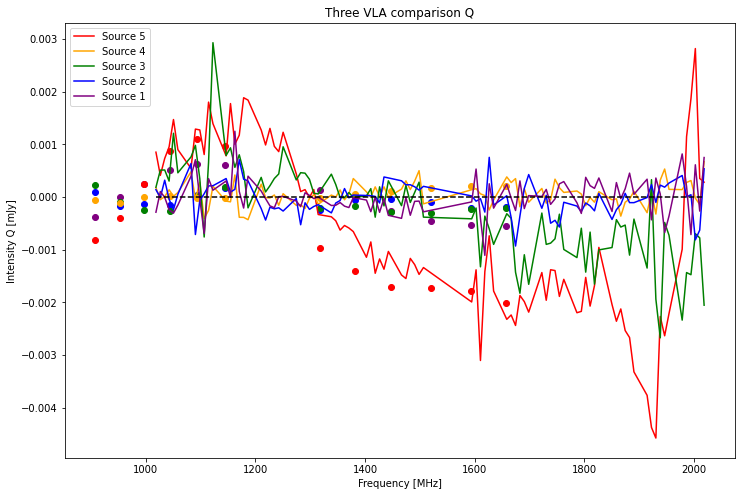

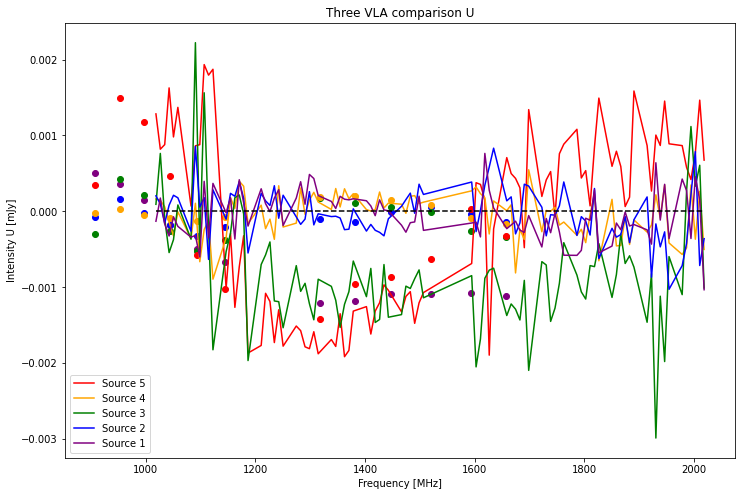

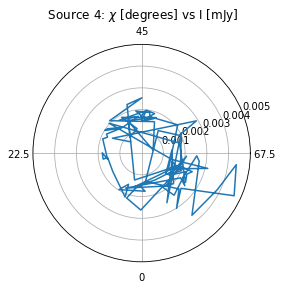

In [13]:
Pol_Angles_VLA = 0.5*np.arctan(U_phot_table_VLA/Q_phot_table_VLA)
Linpol_VLA = np.sqrt(U_phot_table_VLA**2 + Q_phot_table_VLA**2)
Labels_VLA = ['Source 5', 'Source 4', 'Source 3', 'Source 2', 'Source 1']

color_palette = ['r','orange','g','b','purple']

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison sources intensity')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, I_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.plot(freqs_middle/1e6, I_phot_table_compar[:,n], color=color_palette[4-n])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison degree of polarization')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, 100*Linpol_VLA[:,n]/I_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.plot(freqs_middle/1e6, 100*Linpol_compar[:,n]/I_phot_table_compar[:,n], color=color_palette[4-n])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison Q')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, Q_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.scatter(freqs_middle/1e6, Q_phot_table_compar[:,n], color=color_palette[4-n])
plt.hlines(0, min(Freqs_VLA)/1e6, max(Freqs_VLA)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
#plt.xlim(min(Freqs_VLA), max(freqs_upper))
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison U')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, U_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.scatter(freqs_middle/1e6, U_phot_table_compar[:,n], color=color_palette[4-n])
plt.hlines(0, min(Freqs_VLA)/1e6, max(Freqs_VLA)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_VLA[:,0], Linpol_VLA[:,0])
ax.set_rmax(0.005)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 4: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [14]:
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

I_hist_VLA = np.zeros((12,5))
Q_hist_VLA = np.zeros((12,5))
U_hist_VLA = np.zeros((12,5))
I_hist_VLA_err = np.zeros((12,5))
Q_hist_VLA_err = np.zeros((12,5))
U_hist_VLA_err = np.zeros((12,5))

for n in range(5):
    I_hist_VLA_1,_,_ = stats.binned_statistic(Freqs_VLA, I_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_1)
    I_hist_VLA_2,_,_ = stats.binned_statistic(Freqs_VLA, I_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_2)
    I_hist_VLA[:,n] = np.append(I_hist_VLA_1, I_hist_VLA_2)
    I_hist_VLA_1_err,_,_ = stats.binned_statistic(Freqs_VLA, I_phot_table_VLA[:,n], statistic='std', bins=bins_VLA_1)
    I_hist_VLA_2_err,_,_ = stats.binned_statistic(Freqs_VLA, I_phot_table_VLA[:,n], statistic='std', bins=bins_VLA_2)
    I_hist_VLA_err[:,n] = np.append(I_hist_VLA_1_err, I_hist_VLA_2_err)

    Q_hist_VLA_1,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_1)
    Q_hist_VLA_2,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_2)
    Q_hist_VLA[:,n] = np.append(Q_hist_VLA_1, Q_hist_VLA_2)
    Q_hist_VLA_1_err,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA[:,n], statistic='std', bins=bins_VLA_1)
    Q_hist_VLA_2_err,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA[:,n], statistic='std', bins=bins_VLA_2)
    Q_hist_VLA_err[:,n] = np.append(Q_hist_VLA_1_err, Q_hist_VLA_2_err)

    U_hist_VLA_1,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_1)
    U_hist_VLA_2,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_2)
    U_hist_VLA[:,n] = np.append(U_hist_VLA_1, U_hist_VLA_2)
    U_hist_VLA_1_err,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA[:,n], statistic='std', bins=bins_VLA_1)
    U_hist_VLA_2_err,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA[:,n], statistic='std', bins=bins_VLA_2)
    U_hist_VLA_err[:,n] = np.append(U_hist_VLA_1_err, U_hist_VLA_2_err)

In [15]:
Pol_Angles_VLA_hist = 0.5*np.arctan(U_hist_VLA/Q_hist_VLA)
Linpol_VLA_hist = np.sqrt(U_hist_VLA**2 + Q_hist_VLA**2)
Linpol_VLA_hist_err = (U_hist_VLA*U_hist_VLA_err + Q_hist_VLA*Q_hist_VLA_err)/Linpol_VLA_hist

channels = False
polar = False
angle = False
statistic = False
if channels:
    for n in range(5):
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches(12, 10)
        fig.tight_layout(pad=4.5)

        fig.suptitle('Comparison between VLA and MKT data. Based on separate flux measurements.')
        axs[0,0].errorbar(freqs_middle/1e6, I_hist_VLA[:,n], yerr=I_hist_VLA_err[:,n], label=Labels[n] + ' VLA', color='red', marker='o')
        axs[0,0].plot(freqs_middle/1e6, I_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[0,0].set_title('Intensity vs Frequency')
        axs[0,0].set_xlabel('Frequency [MHz]')
        axs[0,0].set_ylabel('Intensity I [mJy]')
        axs[0,0].legend()

        axs[0,1].errorbar(freqs_middle/1e6, 100*Linpol_VLA_hist[:,n]/I_hist_VLA[:,n], yerr=None, label=Labels[n] + ' VLA', color='red', marker='o')
        axs[0,1].plot(freqs_middle/1e6, 100*Linpol_compar[:,n]/I_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[0,1].set_title('Degree of polarization')
        axs[0,1].set_xlabel('Frequency [MHz]')
        axs[0,1].set_ylabel('Degree of polarization $p$ [%]')
        axs[0,1].legend()

        axs[1,0].errorbar(freqs_middle/1e6, Q_hist_VLA[:,n], yerr=Q_hist_VLA_err[:,n], label=Labels[n] + ' VLA', color='red', marker='o')
        axs[1,0].plot(freqs_middle/1e6, Q_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[1,0].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
        axs[1,0].set_title('Intensity Q')
        axs[1,0].set_xlabel('Frequency [MHz]')
        axs[1,0].set_ylabel('Intensity Q [mJy]')
        axs[1,0].legend()

        axs[1,1].errorbar(freqs_middle/1e6, U_hist_VLA[:,n], yerr=U_hist_VLA_err[:,n], label=Labels[n] + ' VLA', color='red', marker='o')
        axs[1,1].plot(freqs_middle/1e6, U_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[1,1].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
        axs[1,1].set_title('Intensity U')
        axs[1,1].set_xlabel('Frequency [MHz]')
        axs[1,1].set_ylabel('Intensity U [mJy]')
        axs[1,1].legend()

        fig.savefig('VLA_MKT_Compar_Source'+str(n)+'.pdf')
        plt.show()

if polar:
    for n in range(len(sources_compar)):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        fig.set_size_inches(8, 8)
        ax.plot(4*Pol_Angles_compar[:,n], I_phot_table_compar[:,n],color='blue', marker='x')
        ax.plot(4*Pol_Angles_VLA_hist[:,n], I_hist_VLA[:,n],color='red', marker='o')
    #    ax.set_rmax(1.1*np.max(I_hist_VLA[:,n]))
        ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
        ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
        ax.grid(True)
        ax.set_title(r" Source "+str(n+1)+r": $\chi$ [degrees] vs I [mJy]")
        plt.show()

if angle:
    for n in range(len(sources_compar)):
        plt.figure(figsize=(8,6))
        plt.plot(freqs_middle/1e6, Pol_Angles_compar[:,n], color='blue', marker='x')
        plt.plot(freqs_middle/1e6, Pol_Angles_VLA_hist[:,n], color='red', marker='o')
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Angle [Deg]')
        plt.title(r" Source "+str(n+1)+r' Angle vs frequency VLA and MKT comparison (red=VLA, blue=MKT)')
        plt.show()

if statistic:
    colors=['red','orange','green','blue','purple']
    for n in range(5):
        plt.scatter(I_phot_table_compar[:,n], I_hist_VLA[:,n], color=colors[n])
    plt.title('Correlation I intensity')
    plt.xlabel('Meerkat I [mJy]')
    plt.ylabel('VLA I [mJy]')
    plt.show()
    for n in range(5):
        plt.scatter(Q_phot_table_compar[:,n], Q_hist_VLA[:,n], color=colors[n])
    plt.title('Correlation Q intensity')
    plt.xlabel('Meerkat Q [mJy]')
    plt.ylabel('VLA Q [mJy]')
    plt.show()
    for n in range(5):
        plt.scatter(U_phot_table_compar[:,n], U_hist_VLA[:,n], color=colors[n])
    plt.title('Correlation U intensity')
    plt.xlabel('Meerkat U [mJy]')
    plt.ylabel('VLA U [mJy]')
    plt.show()

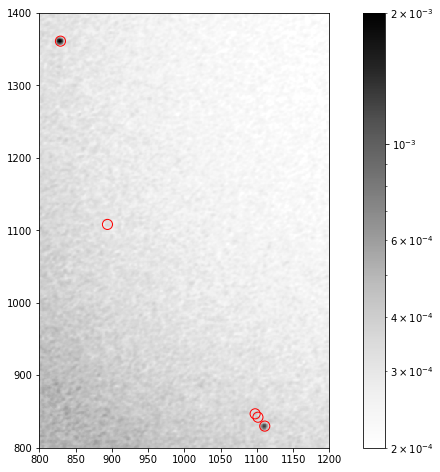

In [35]:
dir_VLA = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data'
fname_pt2 = r'-image.pbcor.smoothed.fits'

import warnings
warnings.filterwarnings("ignore")


Linpol_VLA_hdu = fits.open(get_pkg_data_filename(dir_VLA + r'\Abell_85_VLA_Linpol_Freqmean.fits'))
Linpol_VLA = Linpol_VLA_hdu[0].data.squeeze()

pixsize_VLA = 3.333333333333E-04*c.degree
FWHM_major_axis_VLA = 2.327777777795E-03*c.degree
FWHM_minor_axis_VLA = 2.327777776737E-03*c.degree
Aperturesize_VLA = 7*pixsize/pixsize_VLA
plot_VLA_apers = True

Q_phot_table_VLA_own = np.zeros((90, len(sources_compar)))
U_phot_table_VLA_own = np.zeros((90, len(sources_compar)))

for n in range(90):
    fname_pt1 = r'G115.16-72.09_'+(4-len(str(n)))*'0'+str(n)

    Q_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '\stokes_q\\' + fname_pt1+r'-Q'+fname_pt2))
    Q_plane = Q_hdu[0].data.squeeze() # drops the size-1 axes
    Q_header = Q_hdu[0].header
    Q_wcs_VLA = wcs.WCS(Q_header).celestial
    Q_new_header = Q_wcs_VLA.to_header()

    U_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '\stokes_u\\' + fname_pt1+r'-U'+fname_pt2))
    U_plane = U_hdu[0].data.squeeze() # drops the size-1 axes
    U_header = U_hdu[0].header
    U_wcs_VLA = wcs.WCS(U_header).celestial
    U_new_header = U_wcs_VLA.to_header()

    if n == 0:
        I_wcs_new = wcs.WCS(I_header).celestial
        positions_VLA = np.zeros(np.shape(positions_compar))

        for i in range(len(sources_compar)):
            sky = I_wcs_new.pixel_to_world(positions_compar[i,0],positions_compar[i,1])
            positions_VLA[n] = Q_wcs_VLA.world_to_pixel(sky)

        apertures_VLA = CircularAperture(positions_VLA, r=Aperturesize_VLA)

        if plot_VLA_apers:
            plt.figure(figsize=(12,8))
            #plt.subplot(projection=Q_wcs_VLA)
            plt.imshow(Linpol_VLA.clip(min=0.0002, max=0.002), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
            apertures_VLA.plot(color='red', lw=1)
            plt.colorbar()
            plt.xlim(800,1200)
            plt.ylim(800,1400)
            plt.savefig('Apertures_VLAdata.pdf')

    Q_slice_phot_VLA = photometry(Q_plane, apertures_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA)
    U_slice_phot_VLA = photometry(U_plane, apertures_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA)
    for i in range(len(sources_compar)):
        Q_phot_table_VLA_own[n, i] = Q_slice_phot_VLA[i]['flux']
        U_phot_table_VLA_own[n, i] = U_slice_phot_VLA[i]['flux']

    Q_hdu.close()
    U_hdu.close()

In [36]:
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

I_hist_VLA_own = np.zeros((12,5))
Q_hist_VLA_own = np.zeros((12,5))
U_hist_VLA_own = np.zeros((12,5))
I_hist_VLA_err_own = np.zeros((12,5))
Q_hist_VLA_err_own = np.zeros((12,5))
U_hist_VLA_err_own = np.zeros((12,5))

for n in range(5):
    Q_hist_VLA_1_own,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA_own[:,n], statistic='mean', bins=bins_VLA_1)
    Q_hist_VLA_2_own,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA_own[:,n], statistic='mean', bins=bins_VLA_2)
    Q_hist_VLA_own[:,n] = np.append(Q_hist_VLA_1_own, Q_hist_VLA_2_own)
    Q_hist_VLA_1_err_own,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA_own[:,n], statistic='std', bins=bins_VLA_1)
    Q_hist_VLA_2_err_own,_,_ = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA_own[:,n], statistic='std', bins=bins_VLA_2)
    Q_hist_VLA_err_own[:,n] = np.append(Q_hist_VLA_1_err_own, Q_hist_VLA_2_err_own)

    U_hist_VLA_1_own,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA_own[:,n], statistic='mean', bins=bins_VLA_1)
    U_hist_VLA_2_own,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA_own[:,n], statistic='mean', bins=bins_VLA_2)
    U_hist_VLA_own[:,n] = np.append(U_hist_VLA_1_own, U_hist_VLA_2_own)
    U_hist_VLA_1_err_own,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA_own[:,n], statistic='std', bins=bins_VLA_1)
    U_hist_VLA_2_err_own,_,_ = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA_own[:,n], statistic='std', bins=bins_VLA_2)
    U_hist_VLA_err_own[:,n] = np.append(U_hist_VLA_1_err_own, U_hist_VLA_2_err_own)

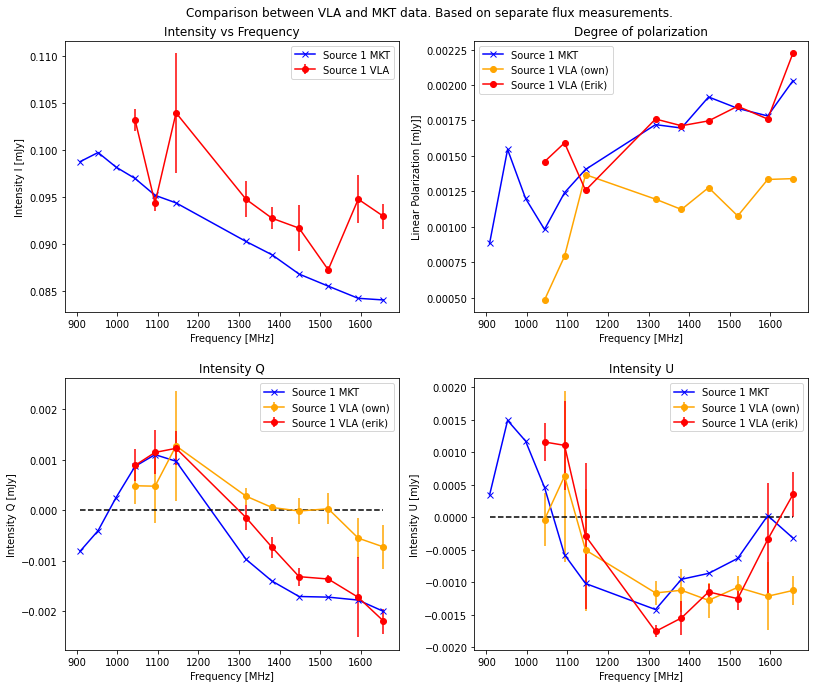

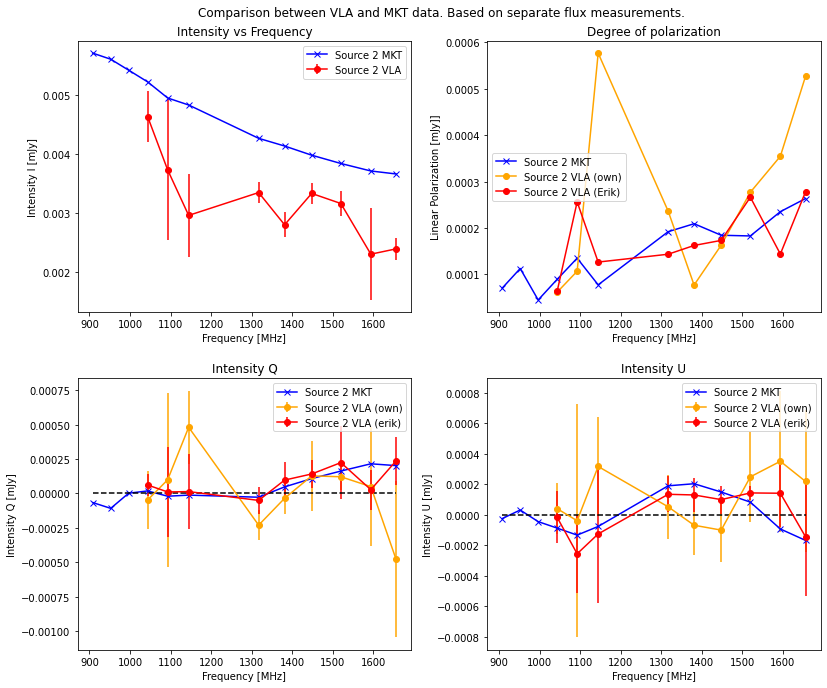

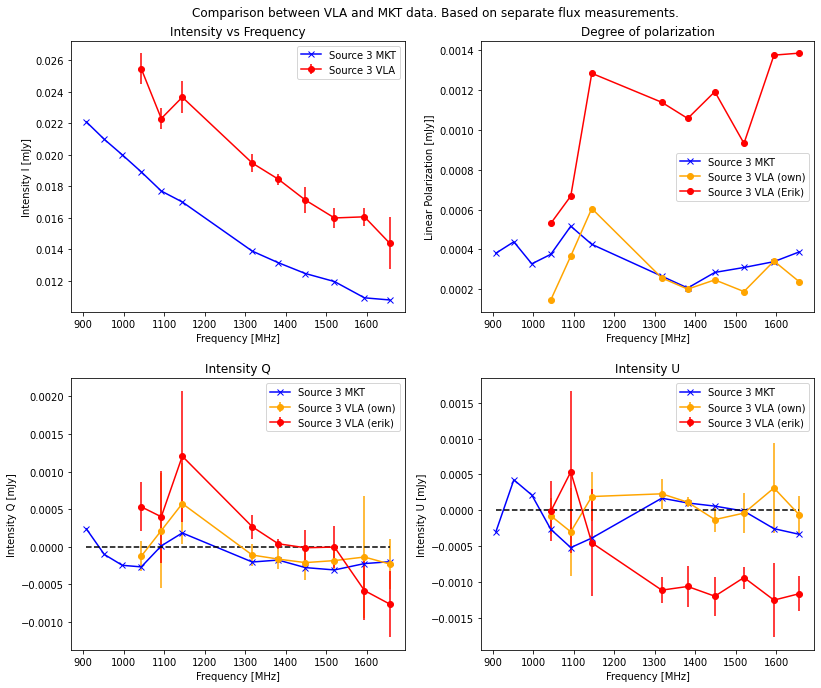

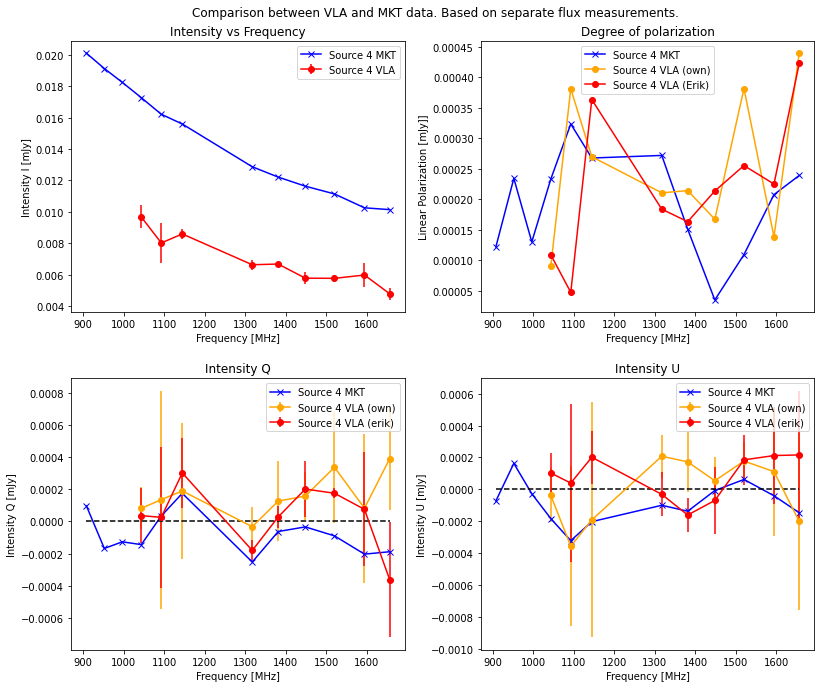

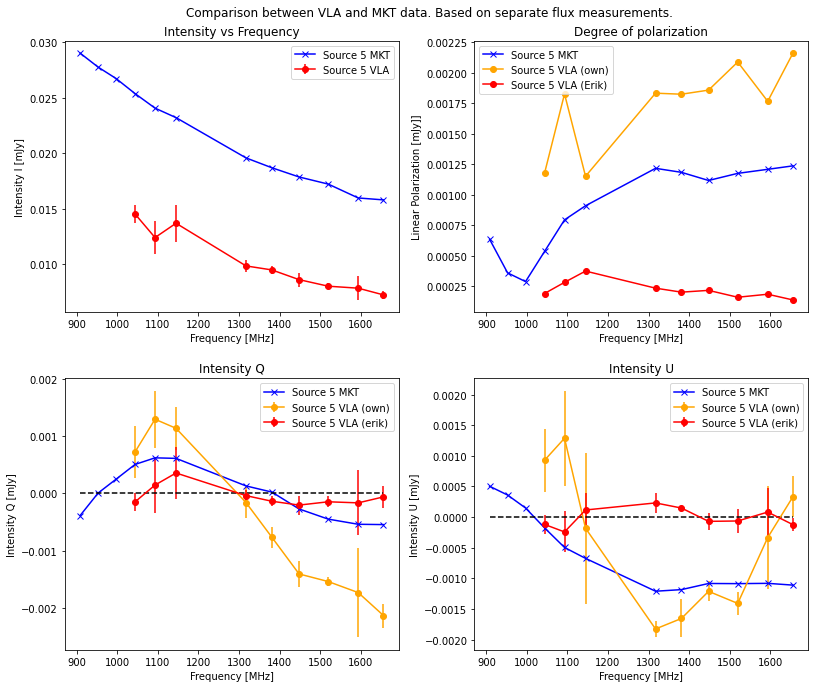

In [37]:
Pol_Angles_VLA_hist_own = 0.5*np.arctan(U_hist_VLA_own/Q_hist_VLA_own)
Linpol_VLA_hist_own = np.sqrt(U_hist_VLA_own**2 + Q_hist_VLA_own**2)
Linpol_VLA_hist_err_own = (U_hist_VLA_own*U_hist_VLA_err_own + Q_hist_VLA_own*Q_hist_VLA_err_own)/Linpol_VLA_hist_own

polar = False
channels = True
angle = False
statistic = False


if channels:
    for n in range(5):
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches(12, 10)
        fig.tight_layout(pad=4.5)

        fig.suptitle('Comparison between VLA and MKT data. Based on separate flux measurements.')
        axs[0,0].errorbar(freqs_middle/1e6, I_hist_VLA[:,n], yerr=I_hist_VLA_err[:,n], label=Labels[n] + ' VLA', color='red', marker='o')
        axs[0,0].plot(freqs_middle/1e6, I_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[0,0].set_title('Intensity vs Frequency')
        axs[0,0].set_xlabel('Frequency [MHz]')
        axs[0,0].set_ylabel('Intensity I [mJy]')
        axs[0,0].legend()

        axs[0,1].errorbar(freqs_middle/1e6, Linpol_VLA_hist_own[:,n], yerr=None, label=Labels[n] + ' VLA (own)', color='orange', marker='o')
        axs[0,1].errorbar(freqs_middle/1e6, Linpol_VLA_hist[:,n], yerr=None, label=Labels[n] + ' VLA (Erik)', color='red', marker='o')
        axs[0,1].plot(freqs_middle/1e6, Linpol_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[0,1].set_title('Degree of polarization')
        axs[0,1].set_xlabel('Frequency [MHz]')
        axs[0,1].set_ylabel('Linear Polarization [mJy]]')
        axs[0,1].legend()

        axs[1,0].errorbar(freqs_middle/1e6, Q_hist_VLA_own[:,n], yerr=Q_hist_VLA_err_own[:,n], label=Labels[n] + ' VLA (own)', color='orange', marker='o')
        axs[1,0].errorbar(freqs_middle/1e6, Q_hist_VLA[:,n], yerr=Q_hist_VLA_err[:,n], label=Labels[n] + ' VLA (erik)', color='red', marker='o')
        axs[1,0].plot(freqs_middle/1e6, Q_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[1,0].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
        axs[1,0].set_title('Intensity Q')
        axs[1,0].set_xlabel('Frequency [MHz]')
        axs[1,0].set_ylabel('Intensity Q [mJy]')
        axs[1,0].legend()

        axs[1,1].errorbar(freqs_middle/1e6, U_hist_VLA_own[:,n], yerr=U_hist_VLA_err_own[:,n], label=Labels[n] + ' VLA (own)', color='orange', marker='o')
        axs[1,1].errorbar(freqs_middle/1e6, U_hist_VLA[:,n], yerr=U_hist_VLA_err[:,n], label=Labels[n] + ' VLA (erik)', color='red', marker='o')
        axs[1,1].plot(freqs_middle/1e6, U_phot_table_compar[:,4-n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[1,1].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
        axs[1,1].set_title('Intensity U')
        axs[1,1].set_xlabel('Frequency [MHz]')
        axs[1,1].set_ylabel('Intensity U [mJy]')
        axs[1,1].legend()

        fig.savefig('VLA_MKT_Compar_Source'+str(n)+'.pdf')
        plt.show()

if polar:
    for n in range(len(sources_compar)):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        fig.set_size_inches(8, 8)
        ax.plot(4*Pol_Angles_compar[:,n], Linpol_compar[:,n],color='blue', marker='x')
        ax.plot(4*Pol_Angles_VLA_hist_own[:,n], Linpol_VLA_hist_own[:,n],color='red', marker='o')
    #    ax.set_rmax(1.1*np.max(I_hist_VLA[:,n]))
        ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
        ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
        ax.grid(True)
        ax.set_title(r" Source "+str(n+1)+r": $\chi$ [degrees] vs Linpol [mJy]")
        plt.show()

if angle:
    for n in range(len(sources_compar)):
        plt.figure(figsize=(8,6))
        plt.plot(freqs_middle/1e6, Pol_Angles_compar[:,n], color='blue', marker='x')
        plt.plot(freqs_middle/1e6, Pol_Angles_VLA_hist_own[:,n], color='red', marker='o')
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Angle [Deg]')
        plt.title(r" Source "+str(n+1)+r' Angle vs frequency VLA and MKT comparison (red=VLA, blue=MKT)')
        plt.show()

if statistic:
    colors=['red','orange','green','blue','purple']
    for n in range(5):
        plt.scatter(Q_phot_table_compar[:,n], Q_hist_VLA_own[:,n], color=colors[n])
    plt.title('Correlation Q intensity')
    plt.xlabel('Meerkat Q [mJy]')
    plt.ylabel('VLA Q [mJy]')
    plt.show()
    for n in range(5):
        plt.scatter(U_phot_table_compar[:,n], Q_hist_VLA_own[:,n], color=colors[n])
    plt.title('Correlation U intensity')
    plt.xlabel('Meerkat U [mJy]')
    plt.ylabel('VLA U [mJy]')
    plt.show()